# Part 3 - Nuclei Image Segmentation Tutorial

## Explore the data

In [1]:
%matplotlib inline

from pathlib import Path
import json

import matplotlib.pyplot as plt
import numpy as np
import torch
from torch.optim import SGD
import torch.nn as nn
from torch.nn.functional import binary_cross_entropy_with_logits

from dataset import CellsDataset, PatchedDataset
from model import UNet
from utils import plot_cells, plot_masks, plot_mask_cells

In [2]:
with open("data/train_valid_split.json", "r") as fp:
    train_valid_split = json.load(fp)

train_dirs = [Path(d) for d in train_valid_split["train_dirs"]]
valid_dirs = [Path(d) for d in train_valid_split["valid_dirs"]]

train_cell_ds = CellsDataset(train_dirs)
valid_cell_ds = CellsDataset(valid_dirs)

In [3]:
train_cell_ds[0]

(<PIL.Image.Image image mode=RGB size=256x256 at 0x7F8E20DBFEB8>,
 <PIL.PngImagePlugin.PngImageFile image mode=L size=256x256 at 0x7F8DCD750F60>)

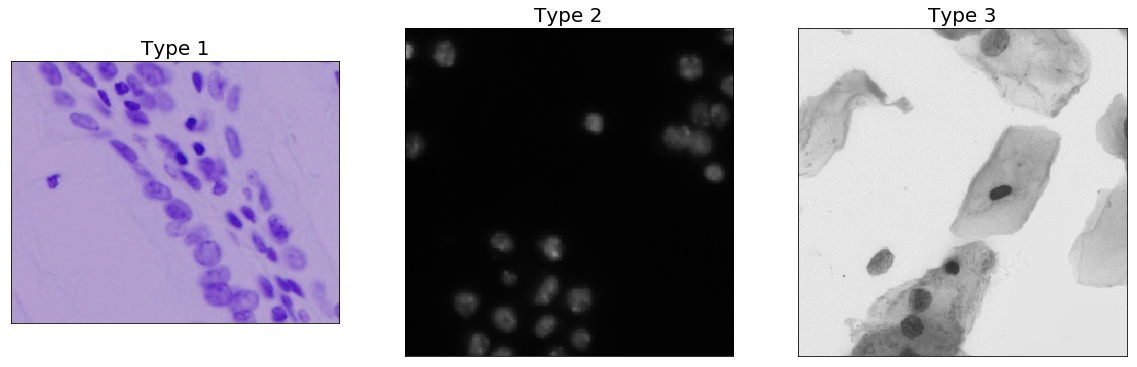

In [4]:
type1_id, type2_id, type3_id = 13, 6, 25
_ = plot_cells(valid_cell_ds[type1_id][0],
           valid_cell_ds[type2_id][0],
           valid_cell_ds[type3_id][0].crop((200, 200, 500, 500)))
plt.savefig("images/seg_types.png")

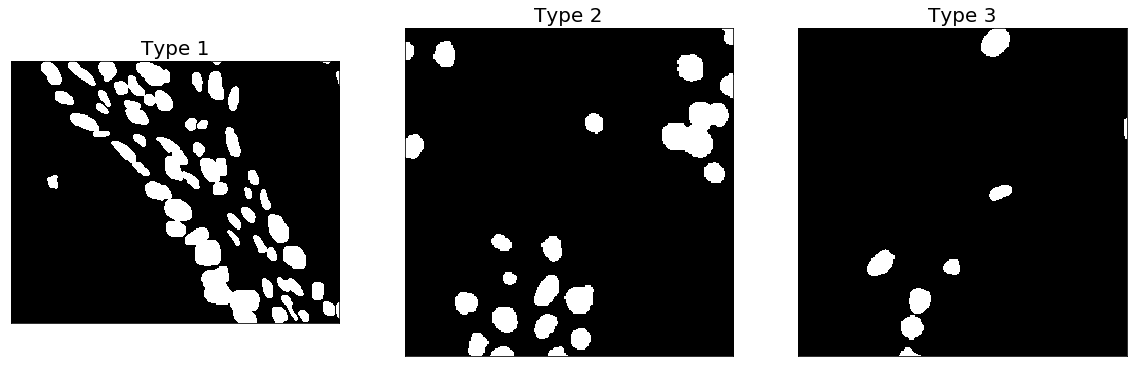

In [5]:
_ = plot_masks(valid_cell_ds[type1_id][1],
               valid_cell_ds[type2_id][1],
               valid_cell_ds[type3_id][1].crop((200, 200, 500, 500)))
plt.savefig("images/seg_type_masks.png")

In [6]:
train_ds = PatchedDataset(
    train_cell_ds, patch_size=(256, 256), padding=16, random_flips=True)
val_ds = PatchedDataset(
    valid_cell_ds, patch_size=(256, 256), padding=16, random_flips=False)

# Padding?

In [7]:
from torchvision.transforms.functional import pad

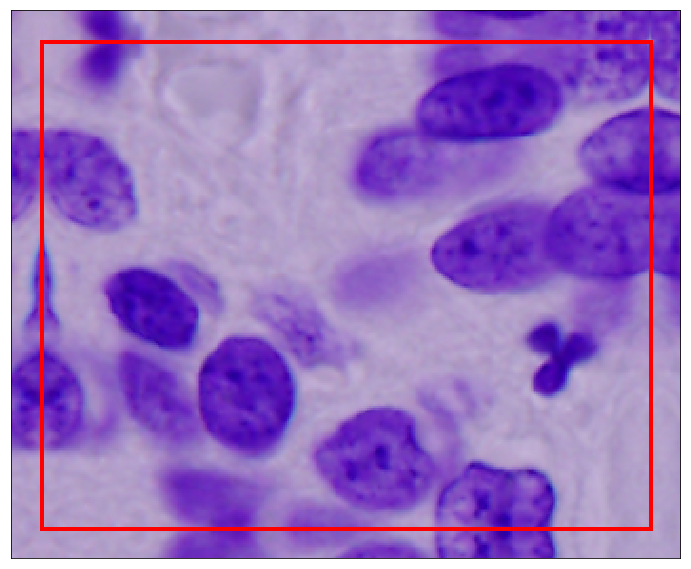

In [8]:
import matplotlib.patches as patches
img = train_cell_ds[3][0]
fig, ax = plt.subplots(figsize=(12, 12))
padded_img = pad(img, 16, padding_mode='reflect')
rect = patches.Rectangle((16,16),320,256,linewidth=4,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.imshow(padded_img)
_ = ax.set_yticks([])
_ = ax.set_xticks([])
fig.savefig("images/seg_reflect.jpg")

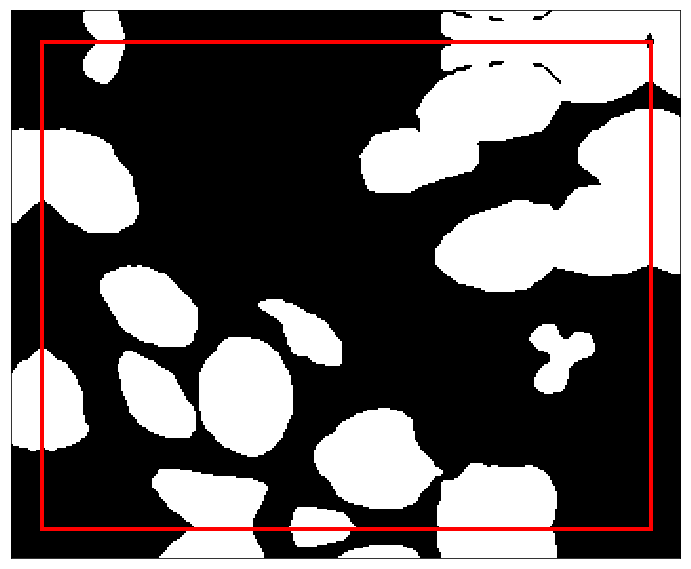

In [9]:
import matplotlib.patches as patches
img = train_cell_ds[3][1]
fig, ax = plt.subplots(figsize=(12, 12))
padded_img = pad(img, 16, padding_mode='reflect')
rect = patches.Rectangle((16,16),320,256,linewidth=4,edgecolor='r',facecolor='none')
ax.add_patch(rect)
ax.imshow(padded_img)
_ = ax.set_yticks([])
_ = ax.set_xticks([])
fig.savefig("images/seg_reflect_mask.jpg")

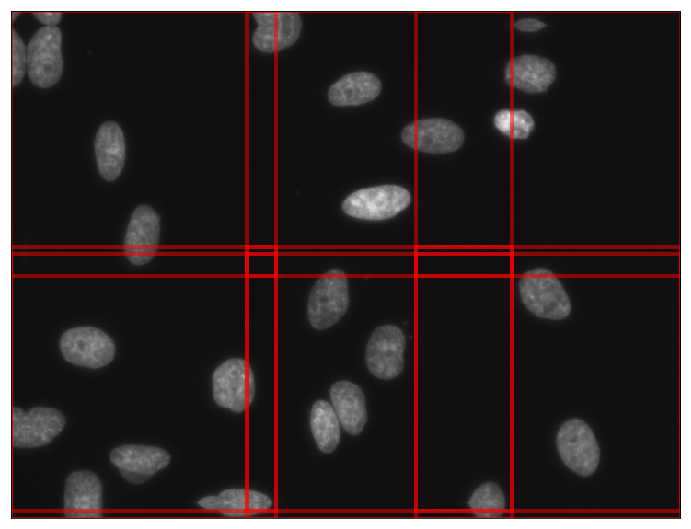

In [10]:
from dataset import calcuate_bboxes
img = train_cell_ds[29][0]
fig, ax = plt.subplots(figsize=(12, 12))
padded_img = pad(img, 16, padding_mode='reflect')
for box in calcuate_bboxes(img.size, (256, 256)):
    rect = patches.Rectangle(box, 256+32, 256+32, linewidth=4, edgecolor='r', facecolor='none', alpha=0.5)
    ax.add_patch(rect)
_ = ax.imshow(padded_img)
_ = ax.set_yticks([])
_ = ax.set_xticks([])
fig.savefig("images/seg_patch.jpg")

## Freezer

In [11]:
from skorch.callbacks import Freezer
freezer = Freezer('conv*')

## Metrics

In [12]:
def approximate_iou_metric(true_masks, predicted_logit_masks, padding=16):
    true_masks = true_masks[:, padding:-padding, padding:-padding]
    predicted_logit_masks = predicted_logit_masks[:, padding:-padding, padding:-padding]
    predicted_masks = 1/(1+np.exp(-predicted_logit_masks))
    
    approx_intersect = np.sum(np.minimum(predicted_masks, true_masks), axis=(1,2))
    approx_union = np.sum(np.maximum(predicted_masks, true_masks), axis=(1,2))
    return np.mean(approx_intersect/approx_union)

In [13]:
from skorch.callbacks import EpochScoring
from sklearn.metrics import make_scorer

iou_scoring = make_scorer(approximate_iou_metric)
iou_scoring = EpochScoring(iou_scoring, name='valid_iou', lower_is_better=False)

## LR Scheduler

In [14]:
from skorch.callbacks import LRScheduler

cyclicLR = LRScheduler(
    policy="CyclicLR", 
    base_lr=0.002, 
    max_lr=0.2,
    step_size_up=550,
    step_size_down=550)

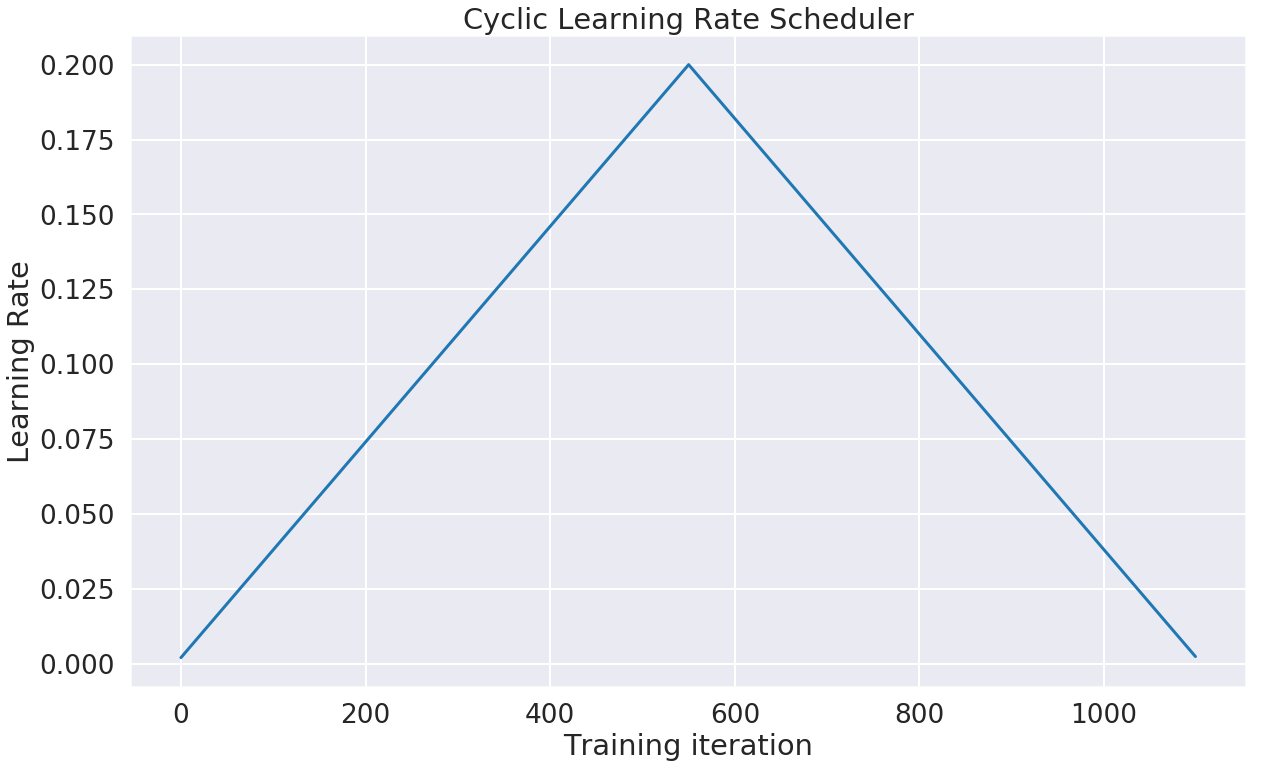

In [15]:
import seaborn as sns
sns.set_style('darkgrid')
sns.set_context('poster', font_scale=1.2)

fig, ax = plt.subplots(figsize=(20, 12))
fig.patch.set_alpha(0)
ax.set_title('Cyclic Learning Rate Scheduler')
ax.set_xlabel('Training iteration')
ax.set_ylabel('Learning Rate')
_ = ax.plot(cyclicLR.simulate(1100, 0.002))
fig.savefig("images/cyclic_lr.png")

## Custom Loss

In [16]:
class BCEWithLogitsLossPadding(nn.Module):
    def __init__(self, padding):
        super().__init__()
        self.padding = padding

    def forward(self, input, target):
        input = input.squeeze_(
            dim=1)[:, self.padding:-self.padding, self.padding:-self.padding]
        target = target.squeeze_(
            dim=1)[:, self.padding:-self.padding, self.padding:-self.padding]
        return binary_cross_entropy_with_logits(input, target)

## Checkpoint

In [17]:
from skorch.callbacks import Checkpoint
best_cp = Checkpoint(dirname="kaggle_seg_exp01", monitor="valid_iou_best")

In [18]:
from skorch.net import NeuralNet
from skorch.helper import predefined_split

net = NeuralNet(
    UNet,
    criterion=BCEWithLogitsLossPadding,
    criterion__padding=16,
    batch_size=32,
    max_epochs=20,
    optimizer=SGD,
    optimizer__momentum=0.9,
    iterator_train__shuffle=True,
    iterator_train__num_workers=4,
    iterator_train__pin_memory=True,
    iterator_valid__shuffle=False,
    iterator_valid__num_workers=4,
    iterator_valid__pin_memory=True,
    train_split=predefined_split(val_ds),
    callbacks=[freezer,
               cyclicLR, 
               iou_scoring,
               best_cp],
    device='cuda',
)

In [19]:
_ = net.fit(train_ds)

  epoch    train_loss    valid_iou    valid_loss    cp      dur
-------  ------------  -----------  ------------  ----  -------
      1        0.4996       0.0797        0.4151     +  48.6801
      2        0.3818       0.1375        0.3349     +  46.5345
      3        0.2848       0.3154        0.2302     +  46.6045
      4        0.1811       0.3189        0.3628     +  46.7507
      5        0.1377       0.6170        0.0951     +  46.8530
      6        0.0806       0.6827        0.0692     +  46.6725
      7        0.0693       0.7083        0.0596     +  46.6736
      8        0.0686       0.7303        0.0669     +  46.5634
      9        0.0656       0.7552        0.0551     +  46.7421
     10        0.0576       0.7480        0.0524        46.7592
     11        0.0641       0.7555        0.0568     +  46.7328
     12        0.0550       0.7484        0.0520        46.9584
     13        0.0532       0.7606        0.0512     +  46.5919
     14        0.0529       0.7722      

In [19]:
net.initialize()
net.load_params(checkpoint=best_cp)

In [20]:
def num_staple_sigmod(x):
    return np.exp(-np.logaddexp(0, -x))

In [21]:
val_masks = net.predict(val_ds)

In [22]:
val_prob_masks = num_staple_sigmod(val_masks.squeeze(1))

In [23]:
print(val_prob_masks.shape)

(468, 288, 288)


## Predictions

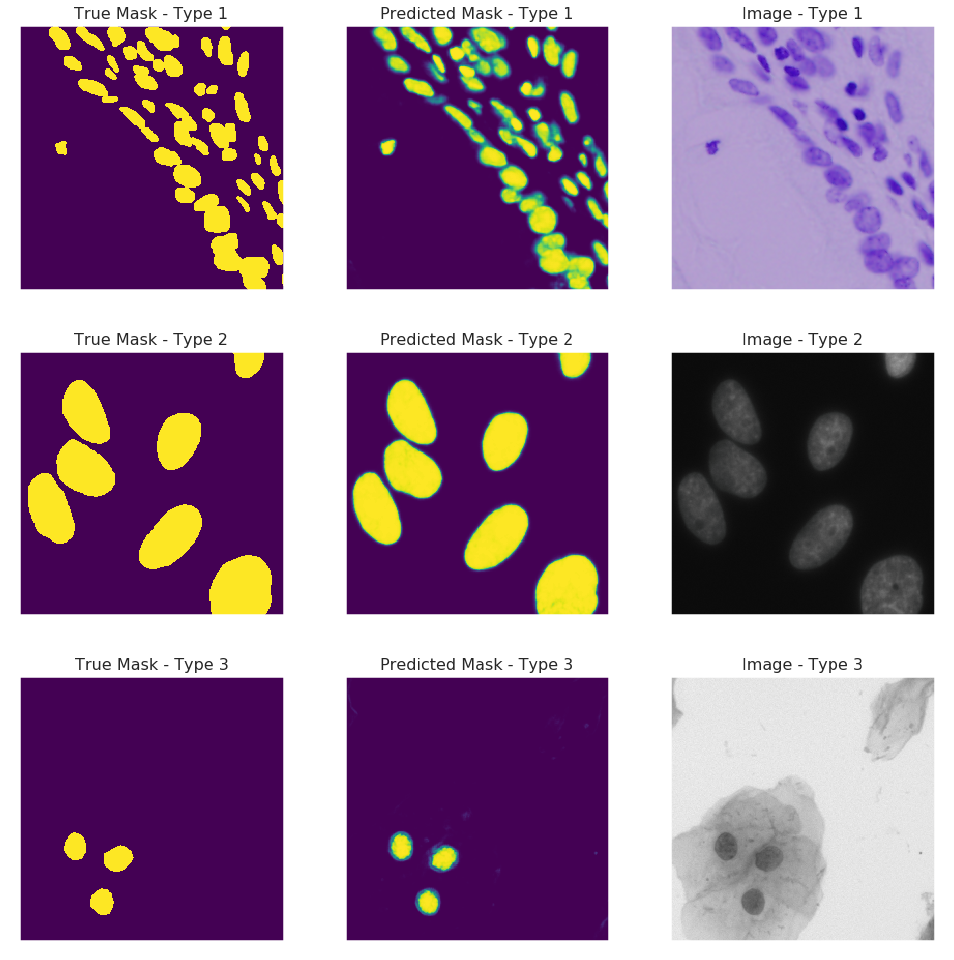

In [38]:
mask_cells = []
for case_id in [45, 8, 81]:
    cell, mask = val_ds[case_id]
    mask_cells.append((mask, val_prob_masks[case_id], cell))

_ = plot_mask_cells(mask_cells)
plt.savefig("images/prediction_seg.jpg")